In [1]:
# PACKAGES

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings("ignore")
from datetime import datetime
from sklearn.preprocessing import OrdinalEncoder,OneHotEncoder
import scipy.stats as stats
import traceback


warnings.filterwarnings('ignore')

from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/Others/'

!ls

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/Others
'Applied DataScience With Pyhthon'  'Machine Learning'	 marketing_data.csv   PROGRAM_REFRESHER


In [2]:
class MarketingCampgian:
  def __init__(self):
    self.df_Marketing = pd.DataFrame()
    self.df_grpbyIncome = pd.DataFrame()

  def LoadDataset(self):
    self.df_Marketing = pd.read_csv('marketing_data.csv')
    self.df_Marketing.columns = self.df_Marketing.columns.str.strip()
    return self.df_Marketing

  def Format_Date_And_Income(self):

    self.df_Marketing['Income'] = self.df_Marketing['Income'].str.replace('[\$,]', '',regex=True).astype(float)
    self.df_Marketing['Dt_Customer'] = pd.to_datetime(self.df_Marketing['Dt_Customer'],errors='coerce')
    self.df_Marketing['Dt_Customer'] = self.df_Marketing['Dt_Customer'].dt.strftime('%d-%m-%Y')

    print('After Cleaning Income column: ', self.df_Marketing['Income'].dtype,'\n', self.df_Marketing['Income'].head(10))
    print('After Cleaning Dt_Customer column: ', self.df_Marketing['Dt_Customer'].dtype,'\n',self.df_Marketing['Dt_Customer'].head(10))
    print('-'*100)

    return self.df_Marketing

  def IncomeMissingValue(self):
    print('Before filling missing value','\n',self.df_Marketing.isna().sum())
    self.df_grpbyIncome = pd.DataFrame(self.df_Marketing.groupby(['Education','Marital_Status'])['Income'].mean()).reset_index()
    print(self.df_grpbyIncome)

    self.df_Marketing['Income'] = self.df_Marketing.apply(self.FillIncomeMiss,axis=1)
    print('After filling missing value','\n',self.df_Marketing.isna().sum())
    return self.df_Marketing

  def TotalChildren(self):
    self.df_Marketing['Total_Children'] = self.df_Marketing['Kidhome']+self.df_Marketing['Teenhome']
    return self.df_Marketing

  def AgeCalculation(self):
    current_year = datetime.now().year
    self.df_Marketing['Age'] = current_year - self.df_Marketing['Year_Birth']
    print(self.df_Marketing.info())
    return self.df_Marketing

  def FillIncomeMiss(self,row):
    if pd.isna(row['Income']):
      return self.df_grpbyIncome[(row['Education']==self.df_grpbyIncome['Education']) &
                                 (row['Marital_Status'] == self.df_grpbyIncome['Marital_Status'])]['Income'].values[0]
    else:
      return row['Income']




  def TotalSpendingAndPurchase(self):
    self.df_Marketing['Total Spending'] = self.df_Marketing['MntWines']+self.df_Marketing['MntFruits']+self.df_Marketing['MntMeatProducts'] + self.df_Marketing['MntFishProducts']+self.df_Marketing['MntSweetProducts'] + self.df_Marketing['MntGoldProds']

    self.df_Marketing['Total Purchase'] = self.df_Marketing['NumDealsPurchases']+self.df_Marketing['NumWebPurchases']+self.df_Marketing['NumCatalogPurchases'] + self.df_Marketing['NumStorePurchases']

    self.df_Marketing['Total Web Purchase'] = self.df_Marketing['NumWebPurchases']+self.df_Marketing['NumCatalogPurchases']

    return self.df_Marketing

  def Plot_Before_After_Otlier(self):
    print('Before Outlier')
    print(self.df_Marketing.describe())

    columns_to_plot = ['Age','Income','Total_Children','Total Spending','Total Purchase']
    df_Plot = self.df_Marketing.copy()

    plt.figure(figsize=(10,10))
    for column in columns_to_plot:
      plt.subplot(5,2,columns_to_plot.index(column)+1)
      sns.boxplot(self.df_Marketing[column])
      plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(10,7))
    for column in columns_to_plot:
      plt.subplot(3,2,columns_to_plot.index(column)+1)
      sns.histplot(data=self.df_Marketing,x = column,kde=True,color = 'green')
      plt.title(f'Boxplot of {column}')
    plt.tight_layout()
    plt.show()

    columns_to_plot = ['Age','Income','Total Spending']
    for column in columns_to_plot:
      lower_bound = df_Plot[column].quantile(0.05)
      upper_bound = df_Plot[column].quantile(0.95)
      df_Plot = df_Plot[(df_Plot[column] >= lower_bound) & (df_Plot[column] <= upper_bound)]

      sns.boxplot(df_Plot[column])
      plt.title(f'Boxplot Outlier Removal{column}')
      plt.tight_layout()
      plt.show()

      sns.histplot(data=df_Plot,x = column,kde=True,color = 'green')
      plt.title(f'Boxplot Outlier Removal {column}')
      plt.tight_layout()
      plt.show()


  def CategoricalEncoder(self):
    Education_order = ['Basic','2n Cycle','Graduation','Master','PhD']
    Edu_Endcoder = OrdinalEncoder(categories=[Education_order])
    self.df_Marketing['Education_Ordinal'] = Edu_Endcoder.fit_transform(self.df_Marketing[['Education']])

    oneht_encoder = pd.get_dummies(self.df_Marketing, columns =['Marital_Status','Country'],drop_first=True)

    self.df_Marketing = pd.concat([self.df_Marketing,oneht_encoder],axis=1)

    return self.df_Marketing


  def HeatMapPlot(self):
    numer_col = self.df_Marketing.select_dtypes('int64','float64').columns
    numer_col = numer_col.drop(['ID','MntWines', 'MntFruits',
       'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts',
       'MntGoldProds', 'NumDealsPurchases', 'NumWebPurchases',
       'NumCatalogPurchases', 'NumStorePurchases', 'NumWebVisitsMonth'])
    corr_matrix = self.df_Marketing[numer_col].corr()
    plt.figure(figsize=(20,20))
    sns.heatmap(corr_matrix,annot=True,cmap='Spectral',fmt='.2f')
    #sns.heatmap(corr_matrix,annot=True,cmap='Spectral',fmt='.2f',mask=np.triu(np.ones_like(corr_matrix,dtype=bool)))
    plt.title('Correlation Matrix')
    plt.tight_layout()
    plt.show()


  def HypoThesisTesting(self):

    print('-'*100)
    print(self.df_Marketing['NumStorePurchases'])
    self.df_Marketing['Age'] = pd.to_numeric(self.df_Marketing['Age'], errors='coerce').fillna(0).astype(int)
    self.df_Marketing['NumStorePurchases'] = pd.to_numeric(self.df_Marketing['NumStorePurchases'], errors='coerce').fillna(0).astype(int)

    corelation_val,p_value = stats.pearsonr(self.df_Marketing['Age'].to_numpy(),self.df_Marketing['NumStorePurchases'].to_numpy())
    print('Corelation between {} and {} is {} and p value is {}'.format('Age','NumStorePurchases',corelation_val,p_value))
    plt.figure(figsize=(10,7))
    sns.scatterplot(data=self.df_Marketing,x='Age',y='NumStorePurchases')

    plt.xlabel('Age')
    plt.ylabel('NumStorePurchases')
    plt.tight_layout()
    plt.show()

  def HypoThesis_Testing(self,x_col,y_col):

    pearson_corr = self.df_Marketing[x_col].corr(self.df_Marketing[y_col])
    print('Pandas corelation: ',pearson_corr)

    corelation_val,p_value = stats.pearsonr(self.df_Marketing[x_col].to_numpy(),self.df_Marketing[y_col].to_numpy())
    print('Corelation between {} and {} is {} and p value is {}'.format(x_col,y_col,corelation_val,p_value))
    plt.figure(figsize=(5,5))
    sns.scatterplot(data=self.df_Marketing,x=x_col,y=y_col)
    plt.xlabel(x_col)
    plt.ylabel(y_col)
    plt.tight_layout()
    plt.show()

    return pearson_corr,corelation_val,p_value

  def HypoThesis_Testing_T(self):
    df_US = self.df_Marketing[self.df_Marketing['Country'] == 'US']
    df_Other = self.df_Marketing[self.df_Marketing['Country'] != 'US']

    df_Purchase_US = df_US['Total Purchase']
    df_Purchase_UK = df_Other['Total Purchase']

    data_for_boxplot = pd.DataFrame({
        'Total Purchase': pd.concat([df_Purchase_US, df_Purchase_UK]),
        'Country': ['US'] * len(df_Purchase_US) + ['Non US'] * len(df_Purchase_UK)
    })

    t_stat,p_value = stats.ttest_ind(df_Purchase_US,df_Purchase_UK)

    plt.figure(figsize=(10,7))
    sns.boxplot(data=data_for_boxplot,notch=True)
    plt.xticks([0,1],['us','non us'])


    plt.ylabel('Total Purchase')
    plt.tight_layout()
    plt.show()

    print('T-statistic: ',t_stat)
    print('P-value: ',p_value)


  def TopPerformingProduct(self):
    total_revenue = self.df_Marketing[['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']].sum()
    # Plot total revenue
    plt.figure(figsize=(10, 6))
    total_revenue.sort_values(ascending=False).plot(kind='bar', color='skyblue')
    plt.title('Total Revenue by Product Category')
    plt.xlabel('Product Category')
    plt.ylabel('Total Revenue')
    plt.show()

  def CorelAgeAceptance(self):
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Age', y='AcceptedCmp1', data=self.df_Marketing)
    plt.title('Age vs Acceptance Rate of the Last Campaign')
    plt.xlabel('Age')
    plt.ylabel('Accepted Campaign 1')
    plt.show()

    # Calculate Pearson correlation coefficient
    correlation, p_value = stats.pearsonr(self.df_Marketing['Age'], self.df_Marketing['AcceptedCmp1'])
    print(f"Pearson correlation coefficient: {correlation:.2f}, p-value: {p_value:.2f}")

  def HighCustCuntry(self):
    # Count of customers who accepted the last campaign by country
    campaign_acceptance = self.df_Marketing[self.df_Marketing['AcceptedCmp1'] == 1]['Country'].value_counts()

    # Plot the results
    plt.figure(figsize=(10, 6))
    campaign_acceptance.plot(kind='bar', color='skyblue')
    plt.title('Number of Customers Who Accepted the Last Campaign by Country')
    plt.xlabel('Country')
    plt.ylabel('Number of Customers')
    plt.show()

  def discrinebelpattern(self):
    # Scatter plot for Total_Children vs. Total_Spending
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='Total_Children', y='Total Spending', data=self.df_Marketing)
    plt.title('Number of Children at Home vs Total Expenditure')
    plt.xlabel('Total Number of Children at Home')
    plt.ylabel('Total Expenditure')
    plt.show()

    # Calculate Pearson correlation coefficient
    correlation, p_value = stats.pearsonr(self.df_Marketing['Total_Children'], self.df_Marketing['Total Spending'])
    print(f"Pearson correlation coefficient: {correlation:.2f}, p-value: {p_value:.2f}")

  def Complaints_Lodged(self):
    complaints = self.df_Marketing[self.df_Marketing['Complain'] == 1]

    # Count of complaints by educational background
    complaints_by_education = complaints['Education'].value_counts()

    # Plot the results
    plt.figure(figsize=(10, 6))
    complaints_by_education.plot(kind='bar', color='skyblue')
    plt.title('Educational Background of Customers Who Lodged Complaints')
    plt.xlabel('Educational Background')
    plt.ylabel('Number of Complaints')
    plt.show()











In [3]:
ObjMarketing = MarketingCampgian()
df = ObjMarketing.LoadDataset()
df_Marketing = df.copy()


In [4]:
ObjMarketing.Format_Date_And_Income()

After Cleaning Income column:  float64 
 0    84835.0
1    57091.0
2    67267.0
3    32474.0
4    21474.0
5    71691.0
6    63564.0
7    44931.0
8    65324.0
9    65324.0
Name: Income, dtype: float64
After Cleaning Dt_Customer column:  object 
 0    16-06-2014
1    15-06-2014
2    13-05-2014
3    11-05-2014
4    08-04-2014
5    17-03-2014
6    29-01-2014
7    18-01-2014
8    11-01-2014
9    11-01-2014
Name: Dt_Customer, dtype: object
----------------------------------------------------------------------------------------------------


,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,84835.0,0,0,16-06-2014,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,57091.0,0,0,15-06-2014,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,67267.0,0,1,13-05-2014,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,32474.0,1,1,11-05-2014,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,21474.0,1,0,08-04-2014,0,6,...,2,7,1,0,0,0,0,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,07-03-2013,99,372,...,11,4,0,0,0,0,0,0,0,US
2236,5263,1977,2n Cycle,Married,31056.0,1,0,22-01-2013,99,5,...,3,8,0,0,0,0,0,0,0,SP
2237,22,1976,Graduation,Divorced,46310.0,1,0,03-12-2012,99,185,...,5,8,0,0,0,0,0,0,0,SP
2238,528,1978,Graduation,Married,65819.0,0,0,29-11-2012,99,267,...,10,3,0,0,0,0,0,0,0,IND


In [5]:
ObjMarketing.IncomeMissingValue()

Before filling missing value 
 ID                      0
Year_Birth              0
Education               0
Marital_Status          0
Income                 24
Kidhome                 0
Teenhome                0
Dt_Customer             0
Recency                 0
MntWines                0
MntFruits               0
MntMeatProducts         0
MntFishProducts         0
MntSweetProducts        0
MntGoldProds            0
NumDealsPurchases       0
NumWebPurchases         0
NumCatalogPurchases     0
NumStorePurchases       0
NumWebVisitsMonth       0
AcceptedCmp3            0
AcceptedCmp4            0
AcceptedCmp5            0
AcceptedCmp1            0
AcceptedCmp2            0
Response                0
Complain                0
Country                 0
dtype: int64
     Education Marital_Status        Income
0     2n Cycle       Divorced  49395.130435
1     2n Cycle        Married  46201.100000
2     2n Cycle         Single  53673.944444
3     2n Cycle       Together  44736.410714
4     2n

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumStorePurchases,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country
0,1826,1970,Graduation,Divorced,84835.0,0,0,16-06-2014,0,189,...,6,1,0,0,0,0,0,1,0,SP
1,1,1961,Graduation,Single,57091.0,0,0,15-06-2014,0,464,...,7,5,0,0,0,0,1,1,0,CA
2,10476,1958,Graduation,Married,67267.0,0,1,13-05-2014,0,134,...,5,2,0,0,0,0,0,0,0,US
3,1386,1967,Graduation,Together,32474.0,1,1,11-05-2014,0,10,...,2,7,0,0,0,0,0,0,0,AUS
4,5371,1989,Graduation,Single,21474.0,1,0,08-04-2014,0,6,...,2,7,1,0,0,0,0,1,0,SP
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,07-03-2013,99,372,...,11,4,0,0,0,0,0,0,0,US
2236,5263,1977,2n Cycle,Married,31056.0,1,0,22-01-2013,99,5,...,3,8,0,0,0,0,0,0,0,SP
2237,22,1976,Graduation,Divorced,46310.0,1,0,03-12-2012,99,185,...,5,8,0,0,0,0,0,0,0,SP
2238,528,1978,Graduation,Married,65819.0,0,0,29-11-2012,99,267,...,10,3,0,0,0,0,0,0,0,IND


In [6]:
ObjMarketing.TotalChildren()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,NumWebVisitsMonth,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Total_Children
0,1826,1970,Graduation,Divorced,84835.0,0,0,16-06-2014,0,189,...,1,0,0,0,0,0,1,0,SP,0
1,1,1961,Graduation,Single,57091.0,0,0,15-06-2014,0,464,...,5,0,0,0,0,1,1,0,CA,0
2,10476,1958,Graduation,Married,67267.0,0,1,13-05-2014,0,134,...,2,0,0,0,0,0,0,0,US,1
3,1386,1967,Graduation,Together,32474.0,1,1,11-05-2014,0,10,...,7,0,0,0,0,0,0,0,AUS,2
4,5371,1989,Graduation,Single,21474.0,1,0,08-04-2014,0,6,...,7,1,0,0,0,0,1,0,SP,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,07-03-2013,99,372,...,4,0,0,0,0,0,0,0,US,1
2236,5263,1977,2n Cycle,Married,31056.0,1,0,22-01-2013,99,5,...,8,0,0,0,0,0,0,0,SP,1
2237,22,1976,Graduation,Divorced,46310.0,1,0,03-12-2012,99,185,...,8,0,0,0,0,0,0,0,SP,1
2238,528,1978,Graduation,Married,65819.0,0,0,29-11-2012,99,267,...,3,0,0,0,0,0,0,0,IND,0


In [7]:
ObjMarketing.AgeCalculation()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2240 entries, 0 to 2239
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   2240 non-null   int64  
 1   Year_Birth           2240 non-null   int64  
 2   Education            2240 non-null   object 
 3   Marital_Status       2240 non-null   object 
 4   Income               2240 non-null   float64
 5   Kidhome              2240 non-null   int64  
 6   Teenhome             2240 non-null   int64  
 7   Dt_Customer          2240 non-null   object 
 8   Recency              2240 non-null   int64  
 9   MntWines             2240 non-null   int64  
 10  MntFruits            2240 non-null   int64  
 11  MntMeatProducts      2240 non-null   int64  
 12  MntFishProducts      2240 non-null   int64  
 13  MntSweetProducts     2240 non-null   int64  
 14  MntGoldProds         2240 non-null   int64  
 15  NumDealsPurchases    2240 non-null   i

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp3,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Total_Children,Age
0,1826,1970,Graduation,Divorced,84835.0,0,0,16-06-2014,0,189,...,0,0,0,0,0,1,0,SP,0,54
1,1,1961,Graduation,Single,57091.0,0,0,15-06-2014,0,464,...,0,0,0,0,1,1,0,CA,0,63
2,10476,1958,Graduation,Married,67267.0,0,1,13-05-2014,0,134,...,0,0,0,0,0,0,0,US,1,66
3,1386,1967,Graduation,Together,32474.0,1,1,11-05-2014,0,10,...,0,0,0,0,0,0,0,AUS,2,57
4,5371,1989,Graduation,Single,21474.0,1,0,08-04-2014,0,6,...,1,0,0,0,0,1,0,SP,1,35
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,07-03-2013,99,372,...,0,0,0,0,0,0,0,US,1,48
2236,5263,1977,2n Cycle,Married,31056.0,1,0,22-01-2013,99,5,...,0,0,0,0,0,0,0,SP,1,47
2237,22,1976,Graduation,Divorced,46310.0,1,0,03-12-2012,99,185,...,0,0,0,0,0,0,0,SP,1,48
2238,528,1978,Graduation,Married,65819.0,0,0,29-11-2012,99,267,...,0,0,0,0,0,0,0,IND,0,46


In [8]:
ObjMarketing.TotalSpendingAndPurchase()

,ID,Year_Birth,Education,Marital_Status,Income,Kidhome,Teenhome,Dt_Customer,Recency,MntWines,...,AcceptedCmp1,AcceptedCmp2,Response,Complain,Country,Total_Children,Age,Total Spending,Total Purchase,Total Web Purchase
0,1826,1970,Graduation,Divorced,84835.0,0,0,16-06-2014,0,189,...,0,0,1,0,SP,0,54,1190,15,8
1,1,1961,Graduation,Single,57091.0,0,0,15-06-2014,0,464,...,0,1,1,0,CA,0,63,577,18,10
2,10476,1958,Graduation,Married,67267.0,0,1,13-05-2014,0,134,...,0,0,0,0,US,1,66,251,11,5
3,1386,1967,Graduation,Together,32474.0,1,1,11-05-2014,0,10,...,0,0,0,0,AUS,2,57,11,4,1
4,5371,1989,Graduation,Single,21474.0,1,0,08-04-2014,0,6,...,0,0,1,0,SP,1,35,91,8,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2235,10142,1976,PhD,Divorced,66476.0,0,1,07-03-2013,99,372,...,0,0,0,0,US,1,48,689,20,7
2236,5263,1977,2n Cycle,Married,31056.0,1,0,22-01-2013,99,5,...,0,0,0,0,SP,1,47,55,5,1
2237,22,1976,Graduation,Divorced,46310.0,1,0,03-12-2012,99,185,...,0,0,0,0,SP,1,48,309,14,7
2238,528,1978,Graduation,Married,65819.0,0,0,29-11-2012,99,267,...,0,0,0,0,IND,0,46,1383,20,9


Before Outlier
                 ID   Year_Birth         Income      Kidhome     Teenhome  \
count   2240.000000  2240.000000    2240.000000  2240.000000  2240.000000   
mean    5592.159821  1968.805804   52248.748825     0.444196     0.506250   
std     3246.662198    11.984069   25039.981052     0.538398     0.544538   
min        0.000000  1893.000000    1730.000000     0.000000     0.000000   
25%     2828.250000  1959.000000   35538.750000     0.000000     0.000000   
50%     5458.500000  1970.000000   51381.500000     0.000000     0.000000   
75%     8427.750000  1977.000000   68289.750000     1.000000     1.000000   
max    11191.000000  1996.000000  666666.000000     2.000000     2.000000   

           Recency     MntWines    MntFruits  MntMeatProducts  \
count  2240.000000  2240.000000  2240.000000      2240.000000   
mean     49.109375   303.935714    26.302232       166.950000   
std      28.962453   336.597393    39.773434       225.715373   
min       0.000000     0.000000

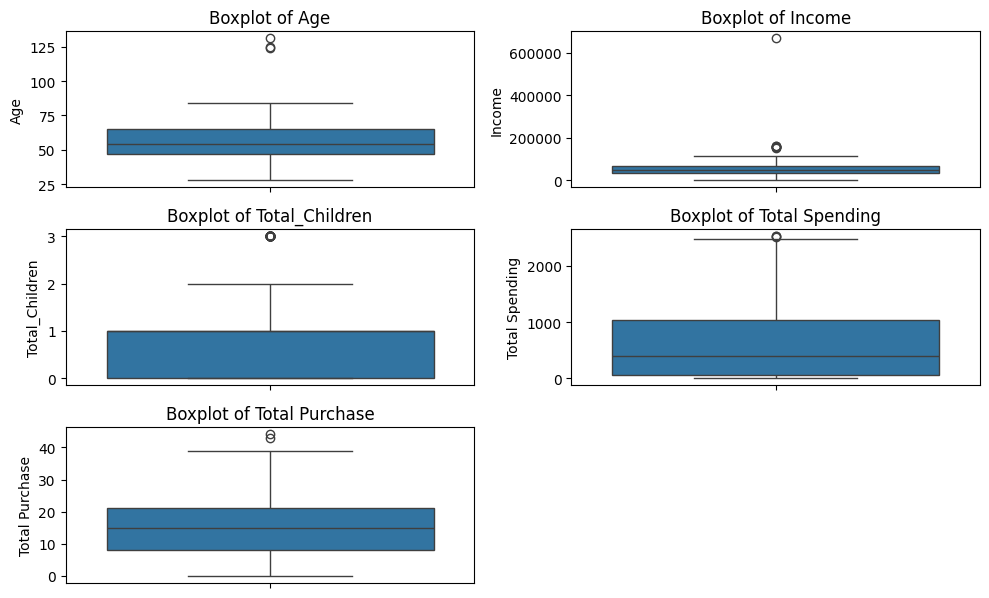

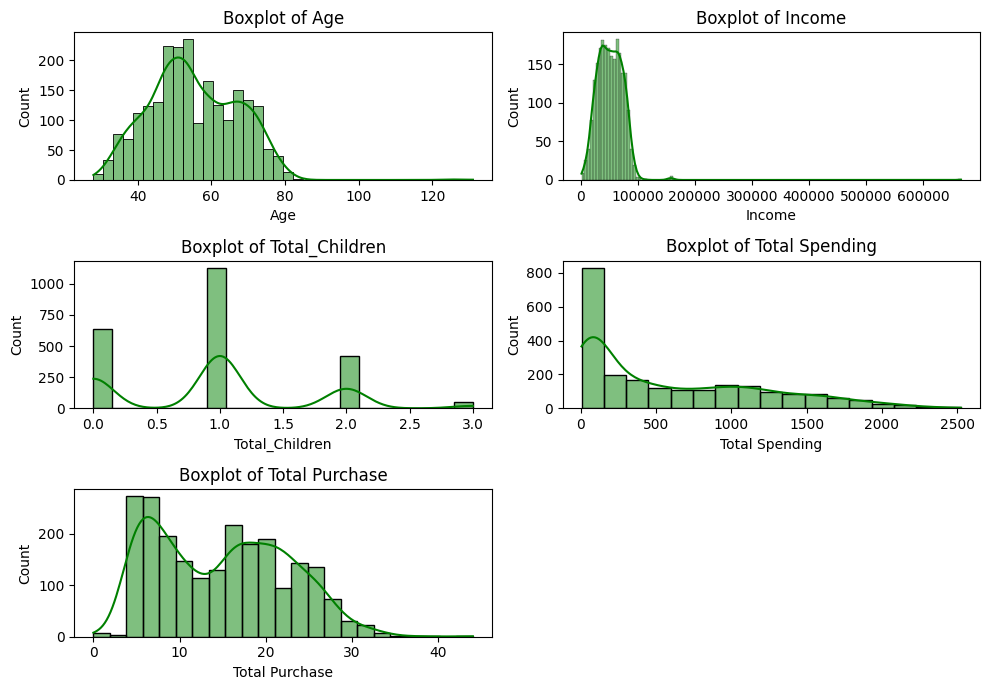

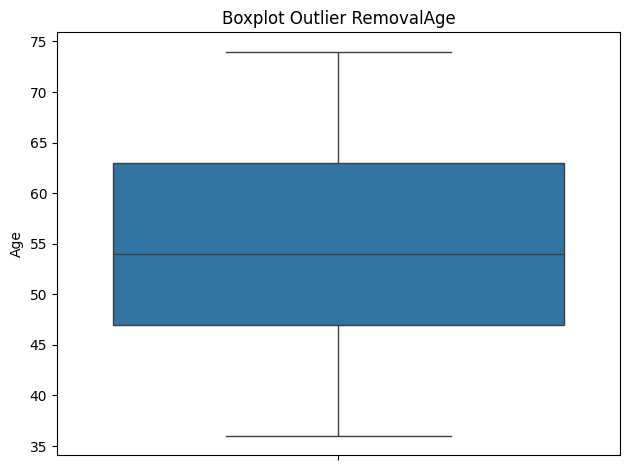

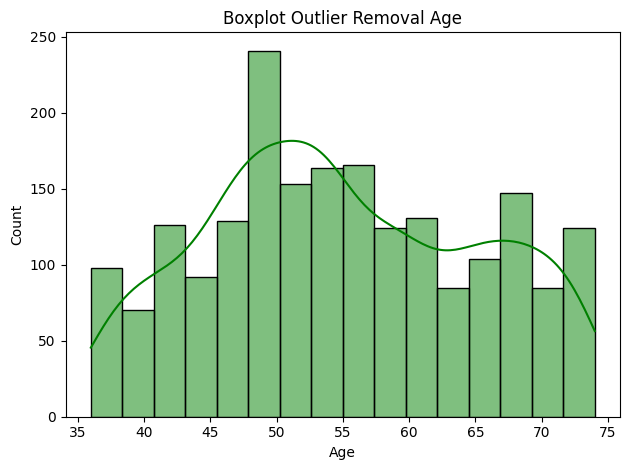

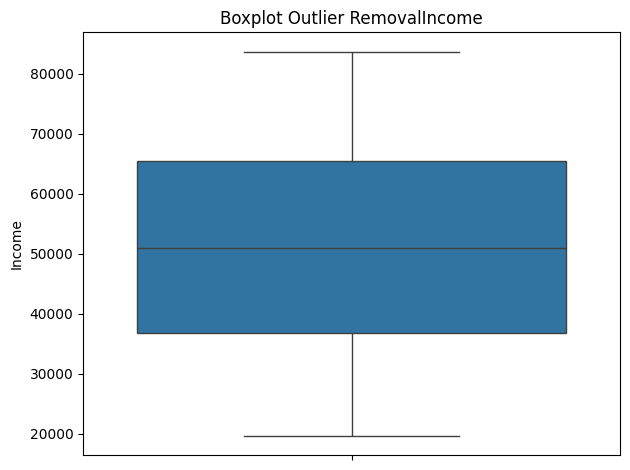

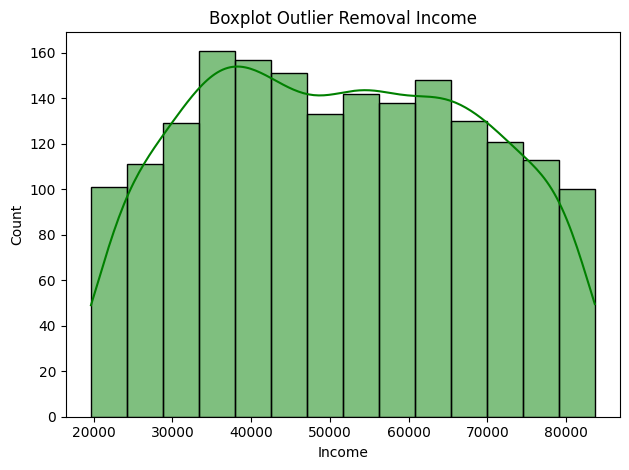

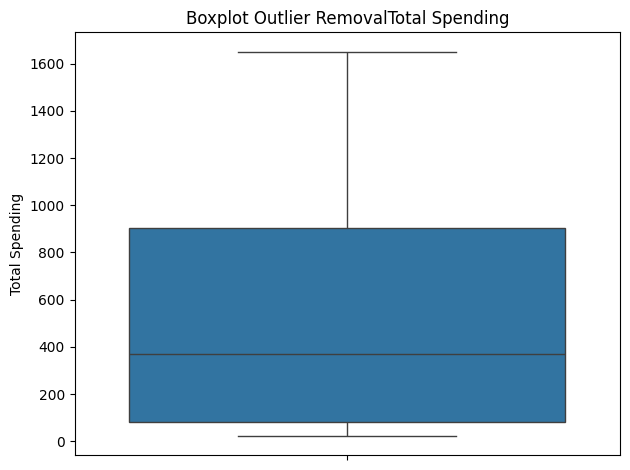

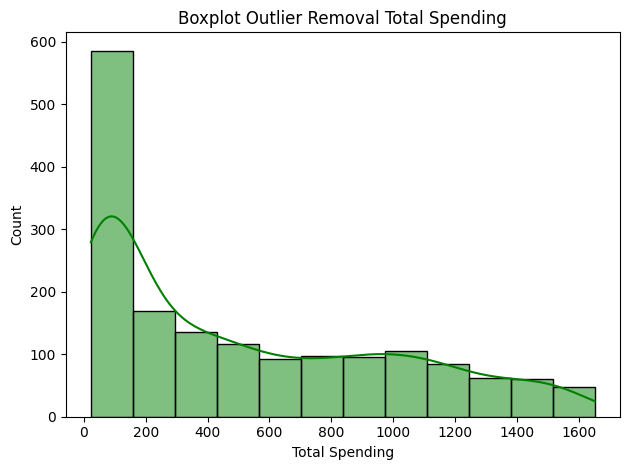

In [9]:
ObjMarketing.Plot_Before_After_Otlier()

In [10]:
#df = ObjMarketing.CategoricalEncoder()

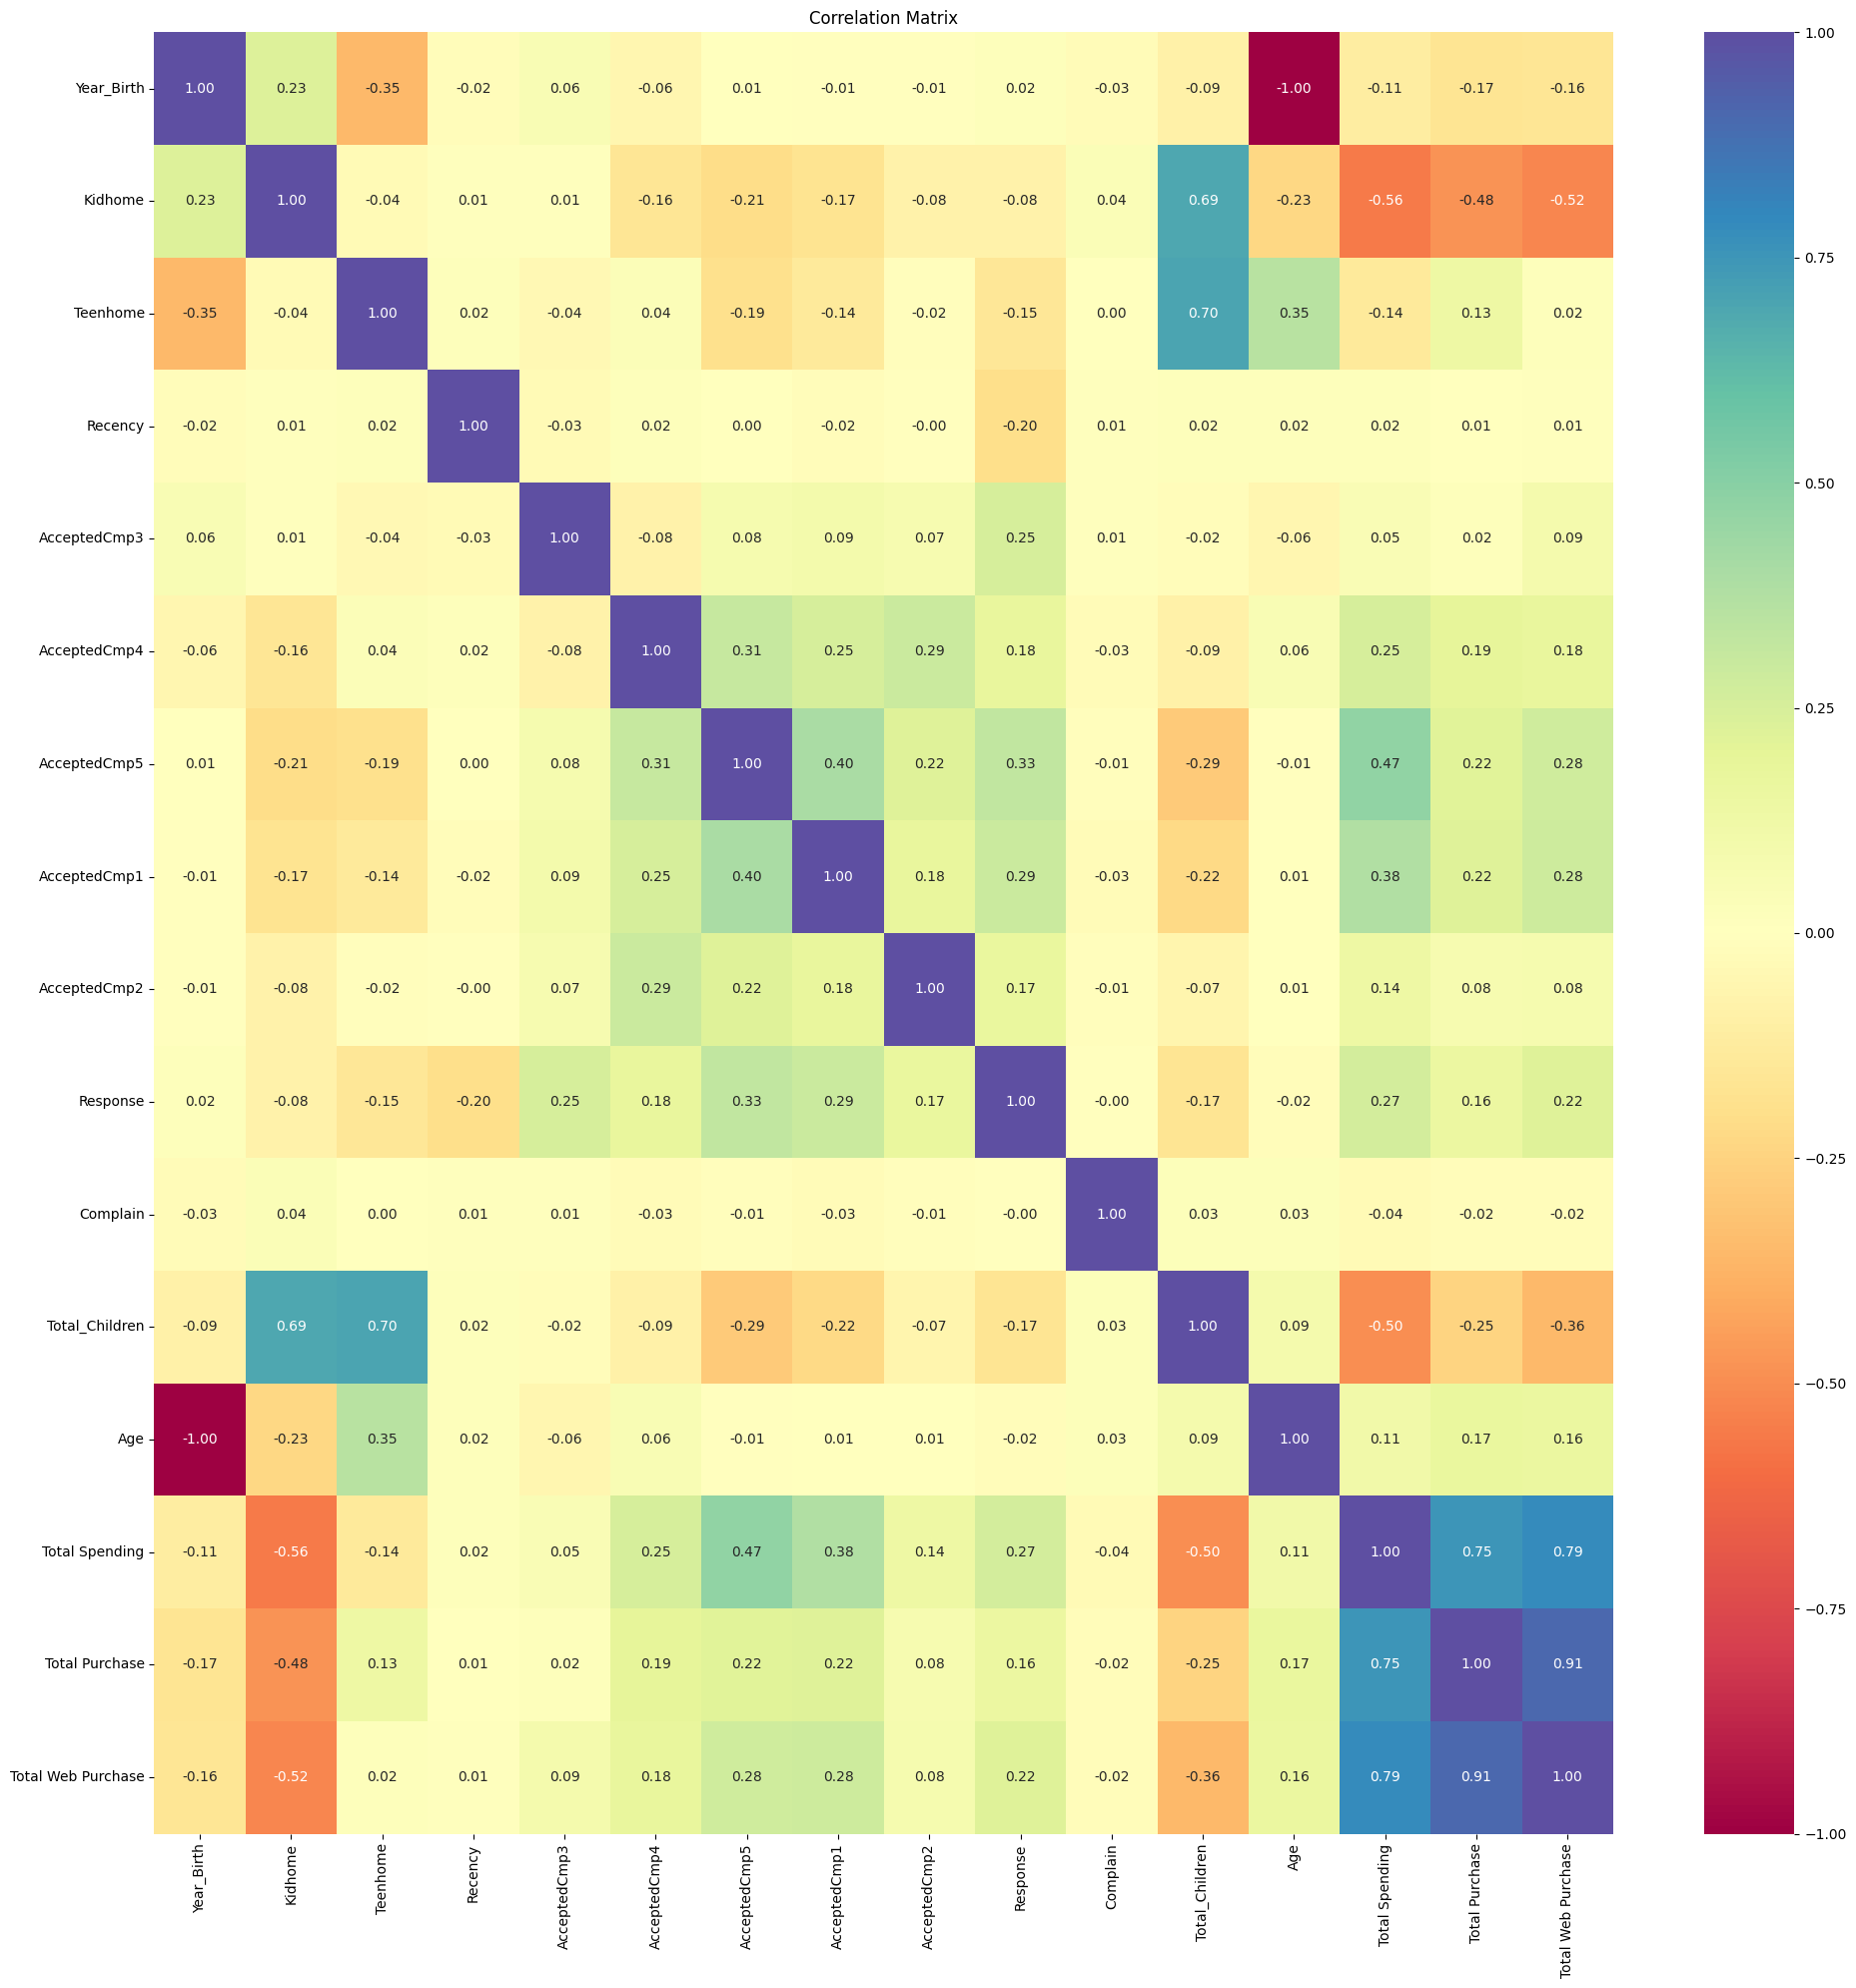

In [11]:
ObjMarketing.HeatMapPlot()

Pandas corelation:  0.12827205559380092
Corelation between Age and NumStorePurchases is 0.12827205559380087 and p value is 1.1099607633898451e-09


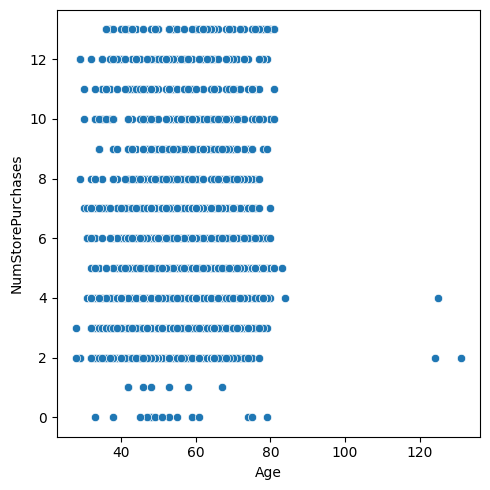

(0.12827205559380092, 0.12827205559380087, 1.1099607633898451e-09)

In [12]:
ObjMarketing.HypoThesis_Testing('Age','NumStorePurchases')

Pandas corelation:  -0.1463609934277097
Corelation between Total_Children and NumWebPurchases is -0.14636099342770997 and p value is 3.3855175912733723e-12


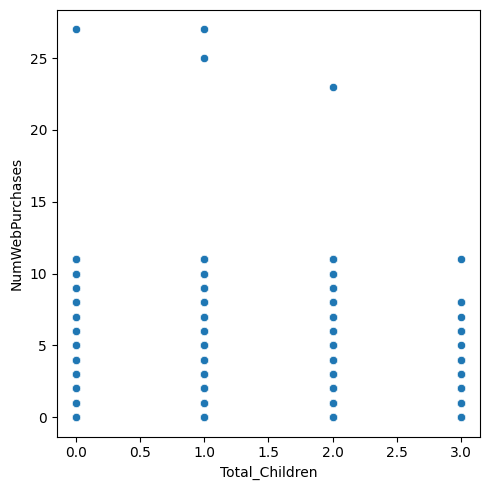

(-0.1463609934277097, -0.14636099342770997, 3.3855175912733723e-12)

In [13]:
ObjMarketing.HypoThesis_Testing('Total_Children','NumWebPurchases')

Pandas corelation:  -0.3575234178559808
Corelation between Total_Children and Total Web Purchase is -0.3575234178559809 and p value is 1.6178115277154918e-68


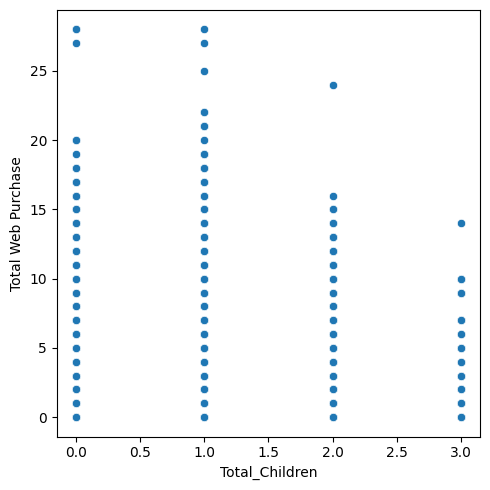

(-0.3575234178559808, -0.3575234178559809, 1.6178115277154918e-68)

In [14]:
ObjMarketing.HypoThesis_Testing('Total_Children','Total Web Purchase')

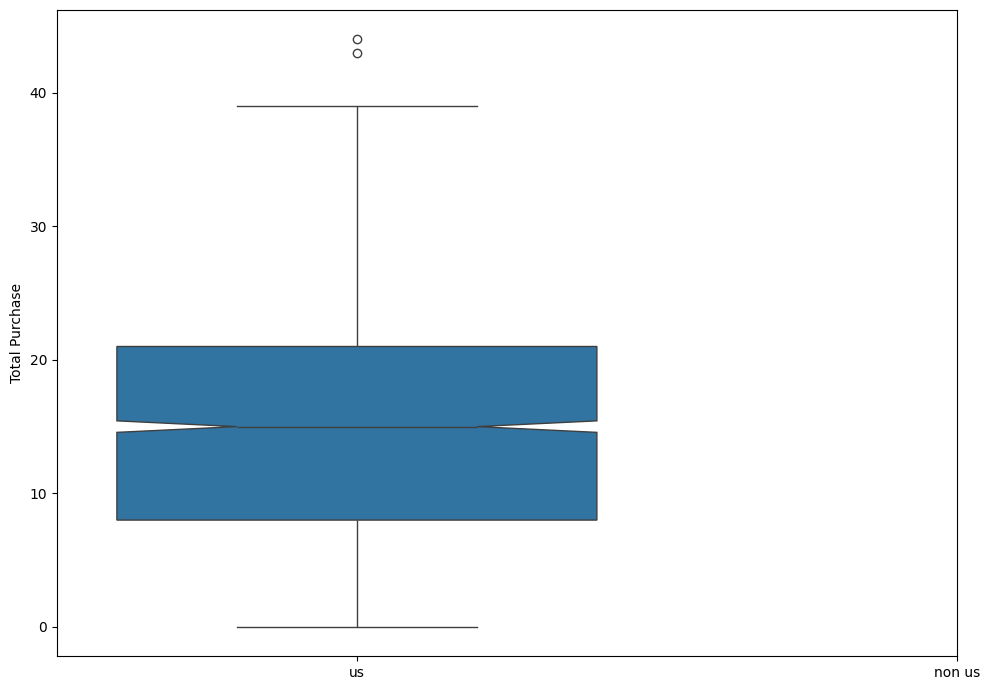

T-statistic:  1.8049578917961837
P-value:  0.07121562869350609


In [15]:
ObjMarketing.HypoThesis_Testing_T()

In [16]:
ObjMarketing.TopPerformingProduct

<bound method MarketingCampgian.TopPerformingProduct of <__main__.MarketingCampgian object at 0x7b310d1789a0>>

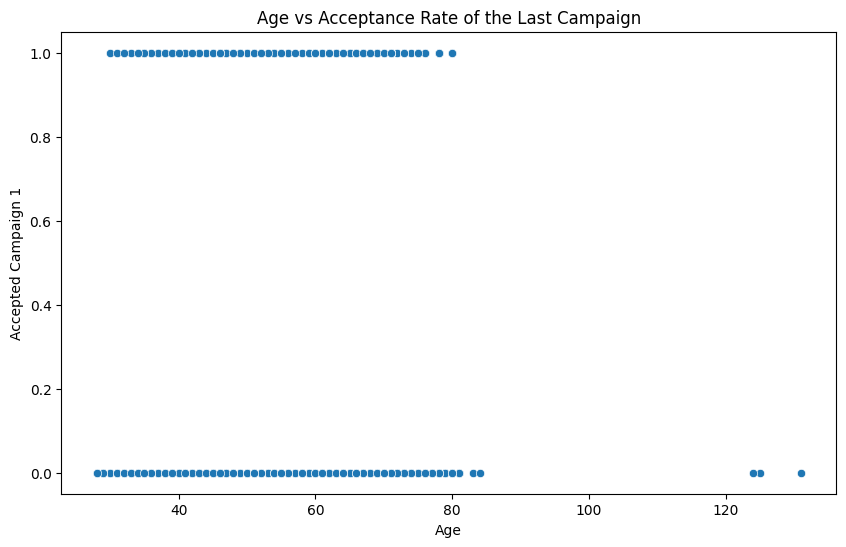

Pearson correlation coefficient: 0.01, p-value: 0.78


In [17]:
ObjMarketing.CorelAgeAceptance()

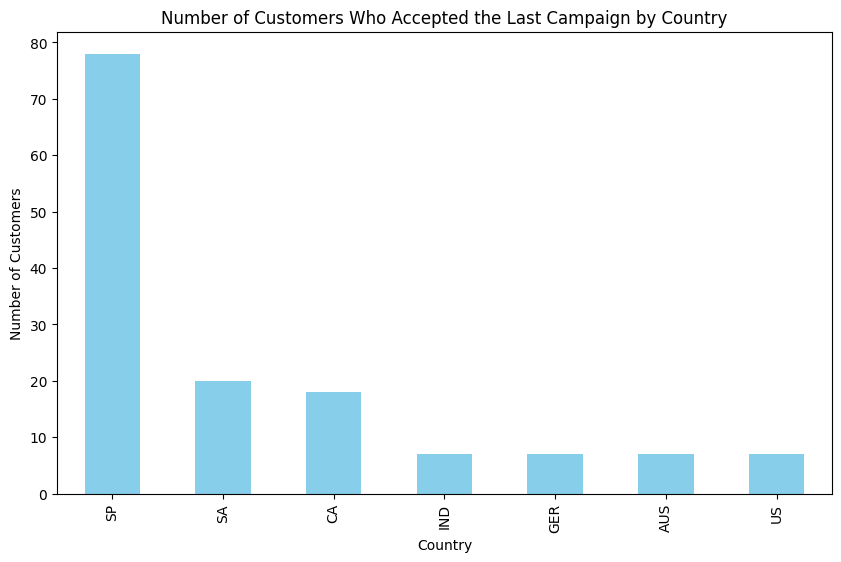

In [18]:
ObjMarketing.HighCustCuntry()

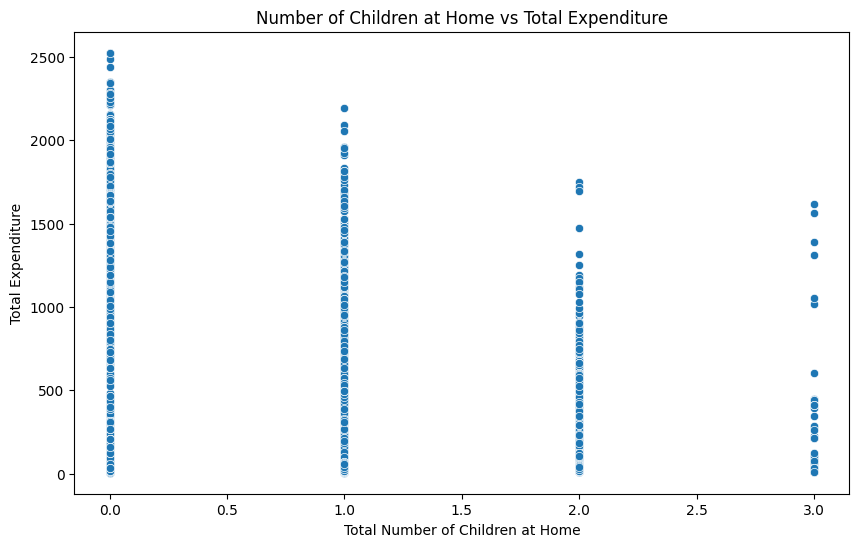

Pearson correlation coefficient: -0.50, p-value: 0.00


In [19]:
ObjMarketing.discrinebelpattern()

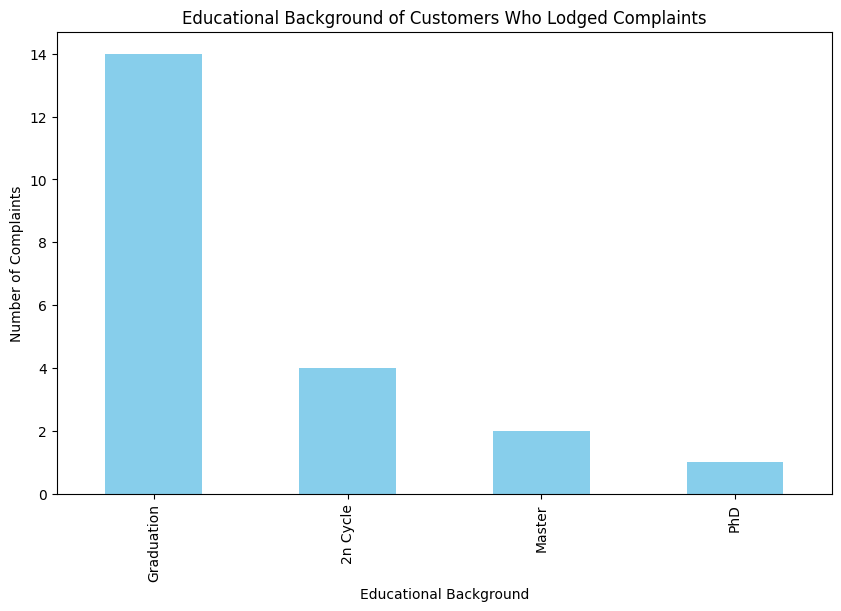

In [20]:
ObjMarketing.Complaints_Lodged()